# Cryptocurrency Price and Volatility Prediction using GRU

This notebook predicts Bitcoin (BTC) and Dogecoin (DOGE) prices and volatility using:
- **Sentiment scores** from TikTok video analysis (stored in results/)
- **Market data** from Yahoo Finance (price, volume, volatility)
- **GRU (Gated Recurrent Unit)** neural networks for time series prediction

## Workflow:
1. Load sentiment analysis results
2. Fetch cryptocurrency price/volume data from Yahoo Finance
3. Feature engineering (technical indicators, lagged features)
4. Build and train GRU models for price and volatility prediction
5. Evaluate model performance and visualize results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Yahoo Finance for price data
import yfinance as yf

# PyTorch for GRU model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: False


In [2]:
# Load multimodal fusion sentiment scores (combines Audio + Visual + Reasoning)
sentiment_multimodal = pd.read_csv('results/multimodal_fusion_sentiment.csv')

# Convert date column to datetime
sentiment_multimodal['date'] = pd.to_datetime(sentiment_multimodal['date'])

print("=" * 80)
print("SENTIMENT DATA LOADED")
print("=" * 80)
print(f"\n📊 Multimodal Fusion Sentiment: {len(sentiment_multimodal)} days")
print(f"   Date range: {sentiment_multimodal['date'].min().date()} to {sentiment_multimodal['date'].max().date()}")
print(f"   Method: {sentiment_multimodal['method'].iloc[0]}")
print(f"   Components: Audio (Whisper) + Visual (CLIP) + Reasoning (Qwen3-VL)")

# Display sample multimodal data
print("\n📋 Sample Multimodal Fusion Sentiment Data:")
display(sentiment_multimodal[['date', 'final_sentiment_score', 'final_sentiment_class', 
                              'audio_score', 'visual_score', 'reasoning_score', 'num_videos']].head(10))

SENTIMENT DATA LOADED

📊 Multimodal Fusion Sentiment: 206 days
   Date range: 2025-01-01 to 2025-07-25
   Method: Multimodal Fusion (Whisper + CLIP + Qwen3-VL)
   Components: Audio (Whisper) + Visual (CLIP) + Reasoning (Qwen3-VL)

📋 Sample Multimodal Fusion Sentiment Data:


,date,final_sentiment_score,final_sentiment_class,audio_score,visual_score,reasoning_score,num_videos
0,2025-01-01,0.619696,POSITIVE,0.402343,0.184807,0.775000,2
1,2025-01-02,0.282012,POSITIVE,0.533918,0.131988,0.288889,9
2,2025-01-03,0.370225,POSITIVE,0.393380,0.184434,0.420000,10
3,2025-01-04,0.372433,POSITIVE,0.545668,0.145582,0.412500,4
4,2025-01-05,0.007004,NEUTRAL,-0.107716,0.110754,-0.006250,8
5,2025-01-06,0.381628,POSITIVE,0.024523,0.241331,0.472727,11
6,2025-01-07,0.175814,NEUTRAL,0.261846,0.223146,0.150000,12
7,2025-01-08,-0.099603,NEUTRAL,-0.162692,0.162177,-0.165385,13
8,2025-01-09,0.178864,NEUTRAL,0.072123,0.158258,0.200000,8
9,2025-01-10,0.173056,NEUTRAL,0.406431,0.204371,0.130769,13


In [4]:
# Define date range based on sentiment data
# Extend the date range to get more historical data
start_date = sentiment_multimodal['date'].min() - timedelta(days=60)  # More buffer for technical indicators
end_date = datetime.now()  # Use current date to get more data

print(f"Fetching price data from {start_date.date()} to {end_date.date()}...")

# Fetch Bitcoin (BTC-USD) data
btc_data = yf.download('BTC-USD', start=start_date, end=end_date, progress=False)
btc_data = btc_data.reset_index()
# Check number of columns and rename accordingly
if len(btc_data.columns) == 7:
    btc_data.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
else:
    btc_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    btc_data['adj_close'] = btc_data['close']  # For crypto, close = adj_close

# Fetch Dogecoin (DOGE-USD) data
doge_data = yf.download('DOGE-USD', start=start_date, end=end_date, progress=False)
doge_data = doge_data.reset_index()
# Check number of columns and rename accordingly
if len(doge_data.columns) == 7:
    doge_data.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
else:
    doge_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    doge_data['adj_close'] = doge_data['close']  # For crypto, close = adj_close

print(f"✅ Bitcoin data: {len(btc_data)} days")
print(f"✅ Dogecoin data: {len(doge_data)} days")

# Display sample
print("\n📋 Sample Bitcoin Data:")
display(btc_data.head())
print("\n📋 Sample Dogecoin Data:")
display(doge_data.head())

Fetching price data from 2024-11-02 to 2025-11-17...
✅ Bitcoin data: 379 days
✅ Dogecoin data: 379 days

📋 Sample Bitcoin Data:
✅ Bitcoin data: 379 days
✅ Dogecoin data: 379 days

📋 Sample Bitcoin Data:


,date,open,high,low,close,volume,adj_close
0,2024-11-02,69289.273438,69867.351562,69033.718750,69486.023438,18184612091,69486.023438
1,2024-11-03,68741.117188,69361.656250,67482.523438,69296.382812,34868307655,69296.382812
2,2024-11-04,67811.507812,69433.179688,66803.648438,68742.132812,41184819348,68742.132812
3,2024-11-05,69359.562500,70522.789062,67458.867188,67811.171875,46046889204,67811.171875
4,2024-11-06,75639.078125,76460.156250,69322.031250,69358.500000,118592653963,69358.500000



📋 Sample Dogecoin Data:


,date,open,high,low,close,volume,adj_close
0,2024-11-02,0.159316,0.163298,0.156035,0.159189,1342216649,0.159189
1,2024-11-03,0.151454,0.159627,0.142823,0.159316,2214868458,0.159316
2,2024-11-04,0.158346,0.159894,0.148581,0.151454,2541759238,0.151454
3,2024-11-05,0.170180,0.178840,0.158179,0.158345,4095671194,0.158345
4,2024-11-06,0.196658,0.213336,0.169694,0.170188,12194137333,0.170188


In [5]:
def add_technical_indicators(df):
    """Add technical indicators and volatility metrics"""
    df = df.copy()
    
    # Returns
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Volatility (rolling standard deviation of returns)
    df['volatility_5d'] = df['returns'].rolling(window=5).std()
    df['volatility_10d'] = df['returns'].rolling(window=10).std()
    df['volatility_20d'] = df['returns'].rolling(window=20).std()
    
    # Moving averages
    df['ma_5'] = df['close'].rolling(window=5).mean()
    df['ma_10'] = df['close'].rolling(window=10).mean()
    df['ma_20'] = df['close'].rolling(window=20).mean()
    
    # Price momentum
    df['momentum_5'] = df['close'] - df['close'].shift(5)
    df['momentum_10'] = df['close'] - df['close'].shift(10)
    
    # Volume features
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_5']
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # High-Low range
    df['high_low_range'] = (df['high'] - df['low']) / df['close']
    
    return df

# Add technical indicators
print("Adding technical indicators to Bitcoin data...")
btc_data = add_technical_indicators(btc_data)

print("Adding technical indicators to Dogecoin data...")
doge_data = add_technical_indicators(doge_data)

print(" Technical indicators added!")
print(f"\nTotal features: {len(btc_data.columns)}")
print(f"Feature columns: {list(btc_data.columns)}")

Adding technical indicators to Bitcoin data...
Adding technical indicators to Dogecoin data...
 Technical indicators added!

Total features: 26
Feature columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close', 'returns', 'log_returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'ma_5', 'ma_10', 'ma_20', 'momentum_5', 'momentum_10', 'volume_ma_5', 'volume_ratio', 'rsi', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bb_position', 'high_low_range']


In [6]:
def merge_sentiment_with_price(price_df, sentiment_df):
    """Merge multimodal sentiment scores with price data"""
    # Select sentiment columns from multimodal fusion
    sent = sentiment_df[['date', 'final_sentiment_score', 'audio_score', 
                        'visual_score', 'reasoning_score', 'num_videos']].copy()
    sent = sent.rename(columns={
        'final_sentiment_score': 'sentiment_multimodal',
        'audio_score': 'sentiment_audio',
        'visual_score': 'sentiment_visual',
        'reasoning_score': 'sentiment_reasoning',
        'num_videos': 'num_videos'
    })
    
    # Merge on date
    merged = price_df.merge(sent, on='date', how='left')
    
    # Forward fill sentiment for days without TikTok videos
    sentiment_cols = ['sentiment_multimodal', 'sentiment_audio', 'sentiment_visual', 'sentiment_reasoning']
    for col in sentiment_cols:
        merged[col] = merged[col].fillna(method='ffill')
    merged['num_videos'] = merged['num_videos'].fillna(0)
    
    # Create lagged sentiment features (sentiment from previous days)
    for sentiment_col in sentiment_cols:
        for lag in [1, 3, 7]:
            merged[f'{sentiment_col}_lag{lag}'] = merged[sentiment_col].shift(lag)
    
    return merged

# Merge for Bitcoin using MULTIMODAL fusion sentiment
print("=" * 80)
print("MERGING BITCOIN WITH MULTIMODAL SENTIMENT DATA")
print("=" * 80)
btc_full = merge_sentiment_with_price(btc_data, sentiment_multimodal)

# Merge for Dogecoin using MULTIMODAL fusion sentiment
print("\nMerging Dogecoin with Multimodal sentiment data...")
doge_full = merge_sentiment_with_price(doge_data, sentiment_multimodal)

# Drop rows with NaN values (from rolling windows and lagged features)
btc_full = btc_full.dropna()
doge_full = doge_full.dropna()

print(f"\n✅ Bitcoin dataset: {len(btc_full)} rows with {len(btc_full.columns)} features")
print(f"✅ Dogecoin dataset: {len(doge_full)} rows with {len(doge_full.columns)} features")

# Show sentiment features
sentiment_cols = [col for col in btc_full.columns if 'sentiment' in col]
print(f"\n📊 Sentiment features ({len(sentiment_cols)}):")
for col in sentiment_cols:
    print(f"   • {col}")

print("\n📋 Sample merged data (Bitcoin):")
sample_cols = ['date', 'close', 'volatility_10d', 'sentiment_multimodal', 
               'sentiment_audio', 'sentiment_visual', 'sentiment_reasoning']
display(btc_full[sample_cols].head(10))

MERGING BITCOIN WITH MULTIMODAL SENTIMENT DATA

Merging Dogecoin with Multimodal sentiment data...

✅ Bitcoin dataset: 312 rows with 43 features
✅ Dogecoin dataset: 312 rows with 43 features

📊 Sentiment features (16):
   • sentiment_multimodal
   • sentiment_audio
   • sentiment_visual
   • sentiment_reasoning
   • sentiment_multimodal_lag1
   • sentiment_multimodal_lag3
   • sentiment_multimodal_lag7
   • sentiment_audio_lag1
   • sentiment_audio_lag3
   • sentiment_audio_lag7
   • sentiment_visual_lag1
   • sentiment_visual_lag3
   • sentiment_visual_lag7
   • sentiment_reasoning_lag1
   • sentiment_reasoning_lag3
   • sentiment_reasoning_lag7

📋 Sample merged data (Bitcoin):


,date,close,volatility_10d,sentiment_multimodal,sentiment_audio,sentiment_visual,sentiment_reasoning
67,2025-01-08,96924.164062,0.025133,-0.099603,-0.162692,0.162177,-0.165385
68,2025-01-09,95043.484375,0.025321,0.178864,0.072123,0.158258,0.200000
69,2025-01-10,92494.492188,0.026742,0.173056,0.406431,0.204371,0.130769
70,2025-01-11,94700.835938,0.027699,-0.181214,-0.425966,0.094411,-0.225000
71,2025-01-12,94565.726562,0.027531,-0.094191,0.077856,0.190116,-0.200000
72,2025-01-13,94488.890625,0.026023,0.006329,0.115816,0.196465,-0.063636
73,2025-01-14,94519.007812,0.025529,0.295901,-0.029168,0.352422,0.326190
74,2025-01-15,96534.046875,0.026699,0.490966,0.367190,0.235710,0.581579
75,2025-01-16,100505.296875,0.029924,0.279589,-0.052134,0.479013,0.270000
76,2025-01-17,100025.765625,0.026904,0.241865,-0.130763,0.214412,0.302941


In [7]:
class CryptoDataset(Dataset):
    """PyTorch Dataset for cryptocurrency time series"""
    
    def __init__(self, data, feature_cols, target_col, sequence_length=5):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.sequence_length = sequence_length
        
        # Separate features and target
        self.features = data[feature_cols].values
        self.targets = data[target_col].values
        
        # Normalize features
        self.scaler_X = StandardScaler()
        self.features = self.scaler_X.fit_transform(self.features)
        
        # Normalize target
        self.scaler_y = StandardScaler()
        self.targets = self.scaler_y.fit_transform(self.targets.reshape(-1, 1)).flatten()
        
    def __len__(self):
        return max(0, len(self.features) - self.sequence_length)
    
    def __getitem__(self, idx):
        # Get sequence of features
        X = self.features[idx:idx+self.sequence_length]
        # Get next day target
        y = self.targets[idx+self.sequence_length]
        
        return torch.FloatTensor(X), torch.FloatTensor([y])

def prepare_data(df, target='close', sequence_length=5, train_ratio=0.7):
    """Prepare train/validation datasets"""
    
    # Define feature columns (exclude date and target)
    exclude_cols = ['date', 'open', 'high', 'low', 'adj_close']
    feature_cols = [col for col in df.columns if col not in exclude_cols and col != target]
    
    print(f"Using {len(feature_cols)} features for prediction")
    print(f"Target: {target}")
    print(f"Sequence length: {sequence_length} days")
    print(f"Total samples after dropna: {len(df)}")
    
    # Split into train/validation (70/30 to ensure enough validation data)
    split_idx = int(len(df) * train_ratio)
    train_data = df.iloc[:split_idx]
    val_data = df.iloc[split_idx:]
    
    print(f"\nTrain set: {len(train_data)} days ({df.iloc[0]['date'].date()} to {train_data.iloc[-1]['date'].date()})")
    print(f"Val set: {len(val_data)} days ({val_data.iloc[0]['date'].date()} to {df.iloc[-1]['date'].date()})")
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, feature_cols, target, sequence_length)
    val_dataset = CryptoDataset(val_data, feature_cols, target, sequence_length)
    
    print(f"Train sequences: {len(train_dataset)}, Val sequences: {len(val_dataset)}")
    
    # Check if datasets are valid
    if len(train_dataset) == 0:
        raise ValueError(f"Train dataset is empty! Need at least {sequence_length+1} samples, got {len(train_data)}")
    if len(val_dataset) == 0:
        raise ValueError(f"Validation dataset is empty! Need at least {sequence_length+1} samples in validation set, got {len(val_data)}. Consider reducing sequence_length or getting more data.")
    
    # Store scalers for inverse transform later
    scalers = {
        'X': train_dataset.scaler_X,
        'y': train_dataset.scaler_y
    }
    
    return train_dataset, val_dataset, feature_cols, scalers

# Example: Prepare Bitcoin price prediction data
print("=" * 80)
print("PREPARING BITCOIN PRICE PREDICTION DATA")
print("=" * 80)
btc_train, btc_val, btc_features, btc_scalers = prepare_data(
    btc_full, 
    target='close',
    sequence_length=5,  # Reduced from 10 to 5
    train_ratio=0.7     # Reduced from 0.75 to 0.7
)

print(f"\n Bitcoin datasets ready:")
print(f"   Train sequences: {len(btc_train)}")
print(f"   Val sequences: {len(btc_val)}")
print(f"   Features: {btc_features[:10]}... (showing first 10)")

PREPARING BITCOIN PRICE PREDICTION DATA
Using 37 features for prediction
Target: close
Sequence length: 5 days
Total samples after dropna: 312

Train set: 218 days (2025-01-08 to 2025-08-13)
Val set: 94 days (2025-08-14 to 2025-11-15)
Train sequences: 213, Val sequences: 89

 Bitcoin datasets ready:
   Train sequences: 213
   Val sequences: 89
   Features: ['volume', 'returns', 'log_returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'ma_5', 'ma_10', 'ma_20', 'momentum_5']... (showing first 10)


In [8]:
class GRUPredictor(nn.Module):
    """GRU-based model for cryptocurrency price/volatility prediction"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch, sequence_length, input_size)
        
        # GRU forward pass
        gru_out, hidden = self.gru(x)
        
        # Take the last output
        last_output = gru_out[:, -1, :]
        
        # Fully connected layers
        out = self.relu(self.fc1(last_output))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Create model instance (example with Bitcoin features)
input_size = len(btc_features)
model = GRUPredictor(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)

print(f" GRU Model created!")
print(f"   Input size: {input_size} features")
print(f"   Hidden size: 64")
print(f"   Number of layers: 2")
print(f"\nModel architecture:")
print(model)

 GRU Model created!
   Input size: 37 features
   Hidden size: 64
   Number of layers: 2

Model architecture:
GRUPredictor(
  (gru): GRU(37, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
def train_model(model, train_dataset, val_dataset, epochs=50, batch_size=32, lr=0.001, device='cpu'):
    """Train GRU model with early stopping"""
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Move model to device
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    
    print(f"Training on {device}...")
    print(f"Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {lr}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        train_maes = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_maes.append(torch.abs(y_pred - y_batch).mean().item())
        
        # Validation phase
        model.eval()
        val_losses = []
        val_maes = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                
                val_losses.append(loss.item())
                val_maes.append(torch.abs(y_pred - y_batch).mean().item())
        
        # Calculate average losses
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        avg_train_mae = np.mean(train_maes)
        avg_val_mae = np.mean(val_maes)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_mae'].append(avg_train_mae)
        history['val_mae'].append(avg_val_mae)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, "
                  f"Train MAE: {avg_train_mae:.6f}, Val MAE: {avg_val_mae:.6f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\n Training complete! Best validation loss: {best_val_loss:.6f}")
    
    return model, history

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Create fresh model for Bitcoin price prediction
btc_price_model = GRUPredictor(input_size=len(btc_features), hidden_size=64, num_layers=2, dropout=0.2)

print("=" * 80)
print("TRAINING BITCOIN PRICE PREDICTION MODEL")
print("=" * 80)

# Train model
btc_price_model, btc_price_history = train_model(
    model=btc_price_model,
    train_dataset=btc_train,
    val_dataset=btc_val,
    epochs=100,
    batch_size=16,
    lr=0.001,
    device=device
)

TRAINING BITCOIN PRICE PREDICTION MODEL
Training on cpu...
Epochs: 100, Batch size: 16, Learning rate: 0.001

Training on cpu...
Epochs: 100, Batch size: 16, Learning rate: 0.001

Epoch 1/100 - Train Loss: 0.688358, Val Loss: 0.782605, Train MAE: 0.667547, Val MAE: 0.691658
Epoch 1/100 - Train Loss: 0.688358, Val Loss: 0.782605, Train MAE: 0.667547, Val MAE: 0.691658
Epoch 5/100 - Train Loss: 0.064562, Val Loss: 0.410131, Train MAE: 0.200619, Val MAE: 0.521460
Epoch 5/100 - Train Loss: 0.064562, Val Loss: 0.410131, Train MAE: 0.200619, Val MAE: 0.521460
Epoch 10/100 - Train Loss: 0.052506, Val Loss: 0.372142, Train MAE: 0.179863, Val MAE: 0.501527
Epoch 10/100 - Train Loss: 0.052506, Val Loss: 0.372142, Train MAE: 0.179863, Val MAE: 0.501527
Epoch 15/100 - Train Loss: 0.046594, Val Loss: 0.438192, Train MAE: 0.162517, Val MAE: 0.546124
Epoch 15/100 - Train Loss: 0.046594, Val Loss: 0.438192, Train MAE: 0.162517, Val MAE: 0.546124
Epoch 20/100 - Train Loss: 0.036516, Val Loss: 0.444055,

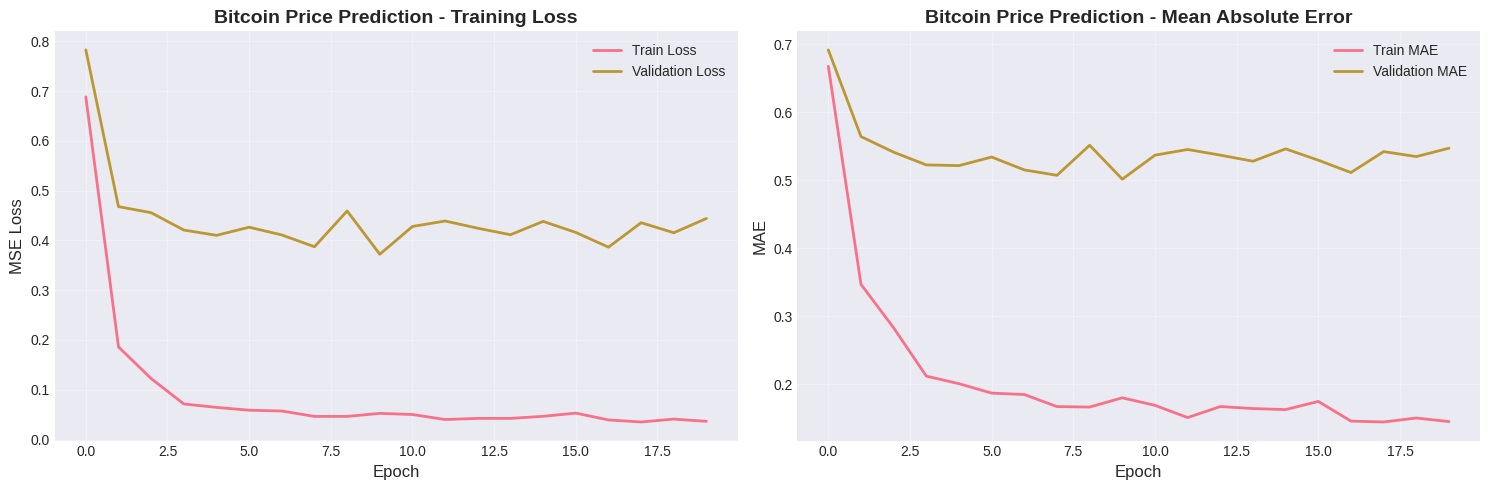

 Training history plot saved to results/btc_price_training_history.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(btc_price_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(btc_price_history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Bitcoin Price Prediction - Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(btc_price_history['train_mae'], label='Train MAE', linewidth=2)
axes[1].plot(btc_price_history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Bitcoin Price Prediction - Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/btc_price_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f" Training history plot saved to results/btc_price_training_history.png")

In [12]:
print("=" * 80)
print("PREPARING BITCOIN VOLATILITY PREDICTION DATA")
print("=" * 80)

# Prepare data for volatility prediction (10-day volatility)
btc_vol_train, btc_vol_val, btc_vol_features, btc_vol_scalers = prepare_data(
    btc_full,
    target='volatility_10d',
    sequence_length=10,
    train_ratio=0.8
)

print(f"\n Bitcoin volatility datasets ready:")
print(f"   Train sequences: {len(btc_vol_train)}")
print(f"   Val sequences: {len(btc_vol_val)}")

# Train model
btc_vol_model = GRUPredictor(input_size=len(btc_vol_features), hidden_size=64, num_layers=2, dropout=0.2)

print("\n" + "=" * 80)
print("TRAINING BITCOIN VOLATILITY PREDICTION MODEL")
print("=" * 80)

btc_vol_model, btc_vol_history = train_model(
    model=btc_vol_model,
    train_dataset=btc_vol_train,
    val_dataset=btc_vol_val,
    epochs=100,
    batch_size=16,
    lr=0.001,
    device=device
)

PREPARING BITCOIN VOLATILITY PREDICTION DATA
Using 37 features for prediction
Target: volatility_10d
Sequence length: 10 days
Total samples after dropna: 312

Train set: 249 days (2025-01-08 to 2025-09-13)
Val set: 63 days (2025-09-14 to 2025-11-15)
Train sequences: 239, Val sequences: 53

 Bitcoin volatility datasets ready:
   Train sequences: 239
   Val sequences: 53

TRAINING BITCOIN VOLATILITY PREDICTION MODEL
Training on cpu...
Epochs: 100, Batch size: 16, Learning rate: 0.001



Epoch 1/100 - Train Loss: 0.820318, Val Loss: 0.602214, Train MAE: 0.628565, Val MAE: 0.612595
Epoch 5/100 - Train Loss: 0.133289, Val Loss: 0.653778, Train MAE: 0.298006, Val MAE: 0.674814
Epoch 5/100 - Train Loss: 0.133289, Val Loss: 0.653778, Train MAE: 0.298006, Val MAE: 0.674814
Epoch 10/100 - Train Loss: 0.103873, Val Loss: 0.606347, Train MAE: 0.239741, Val MAE: 0.656451
Epoch 10/100 - Train Loss: 0.103873, Val Loss: 0.606347, Train MAE: 0.239741, Val MAE: 0.656451
Epoch 15/100 - Train Loss: 0.081806, Val Loss: 0.592742, Train MAE: 0.217327, Val MAE: 0.649777
Epoch 15/100 - Train Loss: 0.081806, Val Loss: 0.592742, Train MAE: 0.217327, Val MAE: 0.649777

Early stopping at epoch 19

 Training complete! Best validation loss: 0.428686

Early stopping at epoch 19

 Training complete! Best validation loss: 0.428686


In [13]:
print("=" * 80)
print("PREPARING DOGECOIN PRICE PREDICTION DATA")
print("=" * 80)

# Price prediction
doge_price_train, doge_price_val, doge_features, doge_scalers = prepare_data(
    doge_full,
    target='close',
    sequence_length=10,
    train_ratio=0.8
)

doge_price_model = GRUPredictor(input_size=len(doge_features), hidden_size=64, num_layers=2, dropout=0.2)

print("\n" + "=" * 80)
print("TRAINING DOGECOIN PRICE PREDICTION MODEL")
print("=" * 80)

doge_price_model, doge_price_history = train_model(
    model=doge_price_model,
    train_dataset=doge_price_train,
    val_dataset=doge_price_val,
    epochs=100,
    batch_size=16,
    lr=0.001,
    device=device
)

# Volatility prediction
print("\n" + "=" * 80)
print("PREPARING DOGECOIN VOLATILITY PREDICTION DATA")
print("=" * 80)

doge_vol_train, doge_vol_val, doge_vol_features, doge_vol_scalers = prepare_data(
    doge_full,
    target='volatility_10d',
    sequence_length=10,
    train_ratio=0.8
)

doge_vol_model = GRUPredictor(input_size=len(doge_vol_features), hidden_size=64, num_layers=2, dropout=0.2)

print("\n" + "=" * 80)
print("TRAINING DOGECOIN VOLATILITY PREDICTION MODEL")
print("=" * 80)

doge_vol_model, doge_vol_history = train_model(
    model=doge_vol_model,
    train_dataset=doge_vol_train,
    val_dataset=doge_vol_val,
    epochs=100,
    batch_size=16,
    lr=0.001,
    device=device
)

PREPARING DOGECOIN PRICE PREDICTION DATA
Using 37 features for prediction
Target: close
Sequence length: 10 days
Total samples after dropna: 312

Train set: 249 days (2025-01-08 to 2025-09-13)
Val set: 63 days (2025-09-14 to 2025-11-15)
Train sequences: 239, Val sequences: 53

TRAINING DOGECOIN PRICE PREDICTION MODEL
Training on cpu...
Epochs: 100, Batch size: 16, Learning rate: 0.001



Epoch 1/100 - Train Loss: 0.599526, Val Loss: 0.246193, Train MAE: 0.577035, Val MAE: 0.384297
Epoch 5/100 - Train Loss: 0.082961, Val Loss: 0.320057, Train MAE: 0.197432, Val MAE: 0.413546
Epoch 5/100 - Train Loss: 0.082961, Val Loss: 0.320057, Train MAE: 0.197432, Val MAE: 0.413546
Epoch 10/100 - Train Loss: 0.051556, Val Loss: 0.248040, Train MAE: 0.164496, Val MAE: 0.347543
Epoch 10/100 - Train Loss: 0.051556, Val Loss: 0.248040, Train MAE: 0.164496, Val MAE: 0.347543
Epoch 15/100 - Train Loss: 0.046570, Val Loss: 0.262188, Train MAE: 0.160789, Val MAE: 0.360101
Epoch 15/100 - Train Loss: 0.046570, Val Loss: 0.262188, Train MAE: 0.160789, Val MAE: 0.360101
Epoch 20/100 - Train Loss: 0.048767, Val Loss: 0.233467, Train MAE: 0.163885, Val MAE: 0.336936
Epoch 20/100 - Train Loss: 0.048767, Val Loss: 0.233467, Train MAE: 0.163885, Val MAE: 0.336936
Epoch 25/100 - Train Loss: 0.040438, Val Loss: 0.227756, Train MAE: 0.149685, Val MAE: 0.339606
Epoch 25/100 - Train Loss: 0.040438, Val Lo

In [21]:
def evaluate_and_plot(model, dataset, scaler_y, data_df, title, save_path, is_validation=True, train_size=0):
    """Evaluate model and create visualization of predictions vs actual
    
    Args:
        model: Trained model
        dataset: Dataset to evaluate (train or validation)
        scaler_y: Scaler for inverse transform
        data_df: Full dataframe with dates
        title: Plot title
        save_path: Path to save plot
        is_validation: If True, offset dates to validation period
        train_size: Size of training set (used to offset validation dates)
    """
    
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    # Inverse transform to original scale
    predictions_orig = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_orig = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(actuals_orig, predictions_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_orig, predictions_orig)
    r2 = r2_score(actuals_orig, predictions_orig)
    mape = np.mean(np.abs((actuals_orig - predictions_orig) / actuals_orig)) * 100
    
    print(f"\n{title} - Evaluation Metrics:")
    print(f"  RMSE: ${rmse:,.2f}" if 'Price' in title else f"  RMSE: {rmse:.6f}")
    print(f"  MAE: ${mae:,.2f}" if 'Price' in title else f"  MAE: {mae:.6f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Get corresponding dates
    sequence_length = dataset.sequence_length
    
    # Calculate date offset based on whether this is validation data
    if is_validation and train_size > 0:
        # For validation: skip training data + sequence_length
        date_offset = train_size + sequence_length
    else:
        # For training: just sequence_length
        date_offset = sequence_length
    
    dates = data_df['date'].iloc[date_offset:date_offset+len(actuals_orig)]
    
    # Plot 1: Time series comparison
    axes[0].plot(dates, actuals_orig, label='Actual', linewidth=2, alpha=0.7)
    axes[0].plot(dates, predictions_orig, label='Predicted', linewidth=2, alpha=0.7)
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].set_title(f'{title} - Predictions vs Actual', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Scatter plot
    axes[1].scatter(actuals_orig, predictions_orig, alpha=0.5, s=30)
    
    # Add diagonal line (perfect prediction)
    min_val = min(actuals_orig.min(), predictions_orig.min())
    max_val = max(actuals_orig.max(), predictions_orig.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[1].set_xlabel('Actual Value', fontsize=12)
    axes[1].set_ylabel('Predicted Value', fontsize=12)
    axes[1].set_title(f'{title} - Scatter Plot (R²={r2:.4f})', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Plot saved to {save_path}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'predictions': predictions_orig,
        'actuals': actuals_orig
    }

print("Evaluating models...")

Evaluating models...



Bitcoin Price Prediction - Evaluation Metrics:
  RMSE: $7,436.44
  MAE: $6,154.72
  R² Score: 0.5621
  MAPE: 6.42%


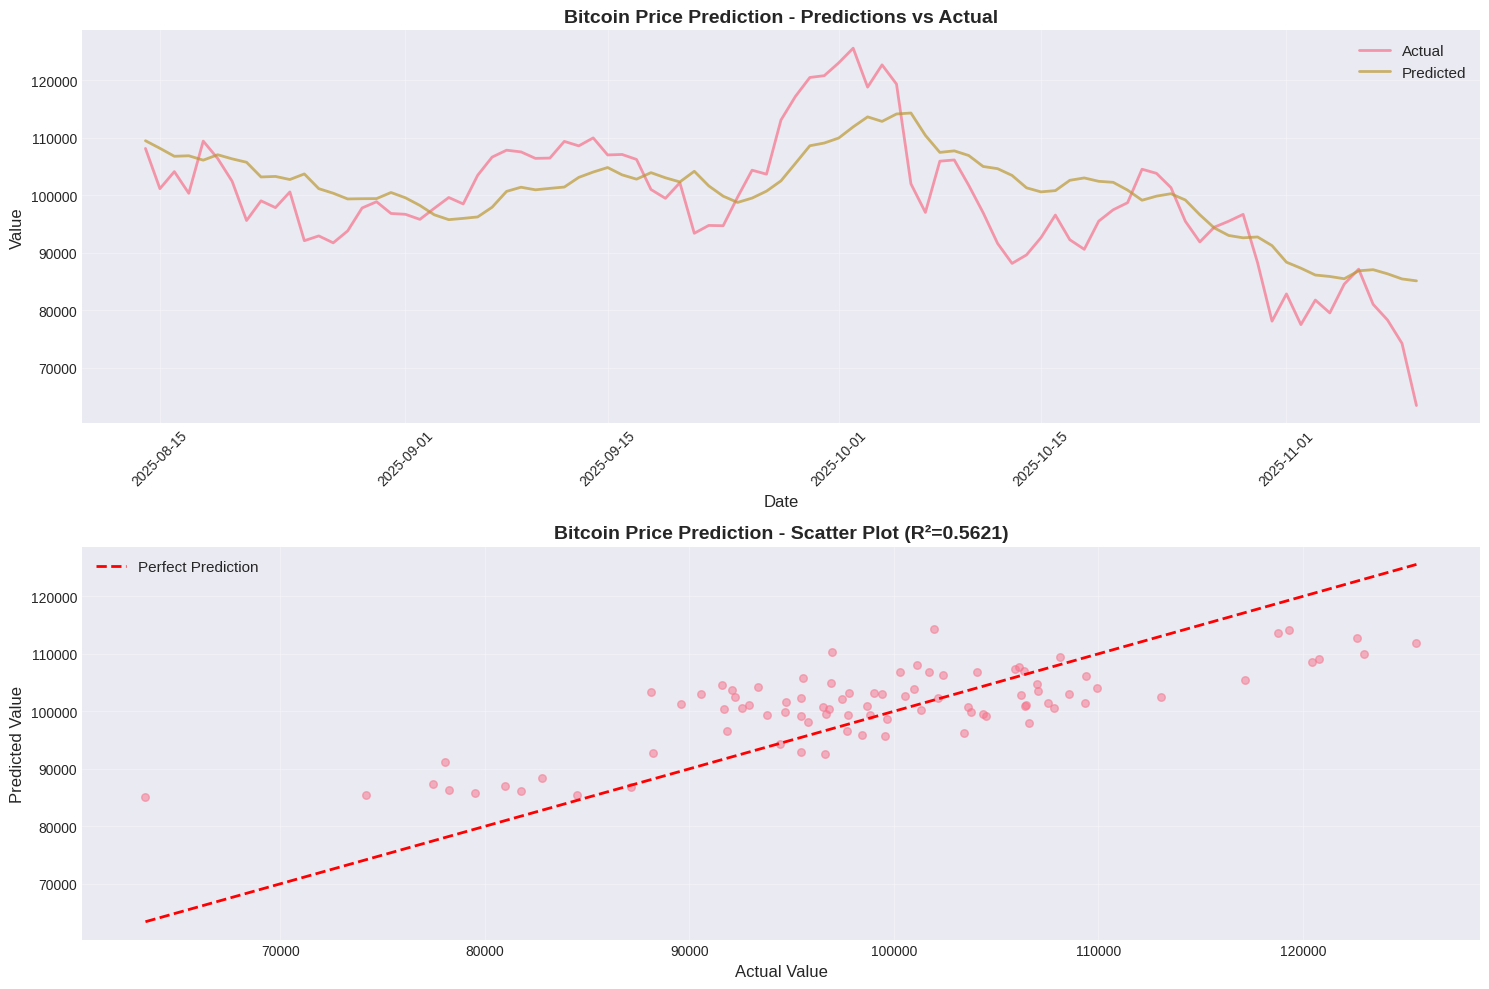

✅ Plot saved to results/btc_price_predictions.png

Bitcoin Volatility Prediction - Evaluation Metrics:
  RMSE: 0.006346
  MAE: 0.005125
  R² Score: 0.3449
  MAPE: 22.56%

Bitcoin Volatility Prediction - Evaluation Metrics:
  RMSE: 0.006346
  MAE: 0.005125
  R² Score: 0.3449
  MAPE: 22.56%


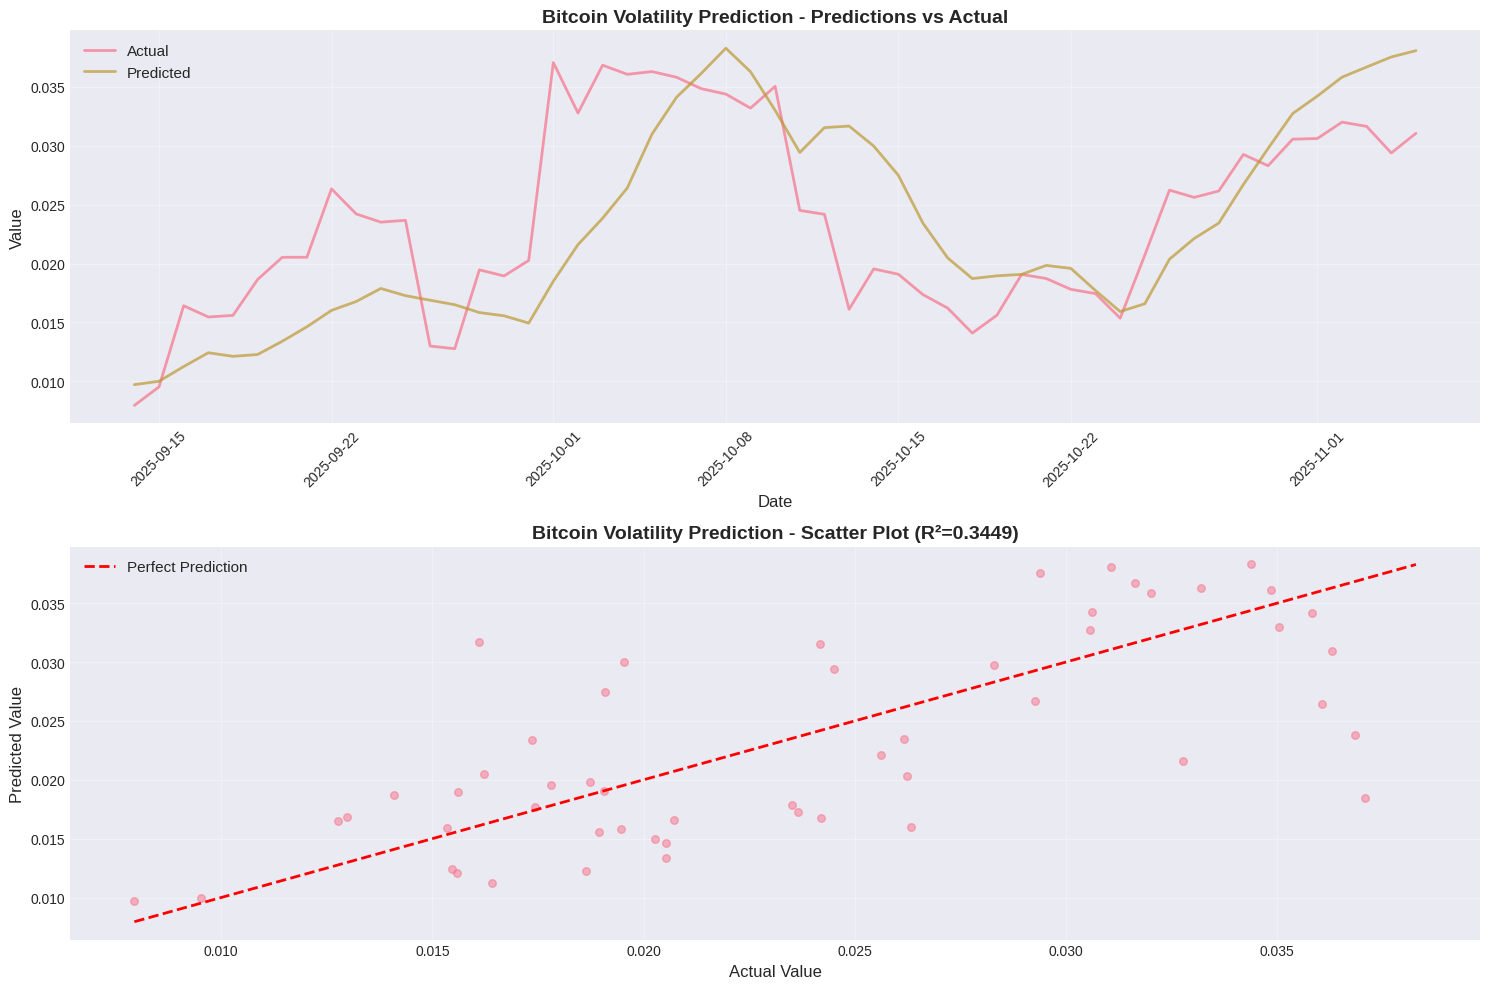

✅ Plot saved to results/btc_volatility_predictions.png


In [22]:
# Evaluate Bitcoin Price Prediction
btc_price_results = evaluate_and_plot(
    model=btc_price_model,
    dataset=btc_val,
    scaler_y=btc_scalers['y'],
    data_df=btc_full,
    title='Bitcoin Price Prediction',
    save_path='results/btc_price_predictions.png',
    is_validation=True,
    train_size=len(btc_train)
)

# Evaluate Bitcoin Volatility Prediction
btc_vol_results = evaluate_and_plot(
    model=btc_vol_model,
    dataset=btc_vol_val,
    scaler_y=btc_vol_scalers['y'],
    data_df=btc_full,
    title='Bitcoin Volatility Prediction',
    save_path='results/btc_volatility_predictions.png',
    is_validation=True,
    train_size=len(btc_vol_train)
)

### 11.1a Full Dataset Prediction (Train + Validation)

Visualize predictions across the entire time range, not just validation set

BITCOIN PRICE PREDICTION - FULL TIME RANGE

Bitcoin Price Prediction - FULL DATASET Evaluation Metrics:
  RMSE: $4,257.00
  MAE: $2,699.89
  R² Score: 0.8622
  MAPE: 2.82%

Bitcoin Price Prediction - FULL DATASET Evaluation Metrics:
  RMSE: $4,257.00
  MAE: $2,699.89
  R² Score: 0.8622
  MAPE: 2.82%


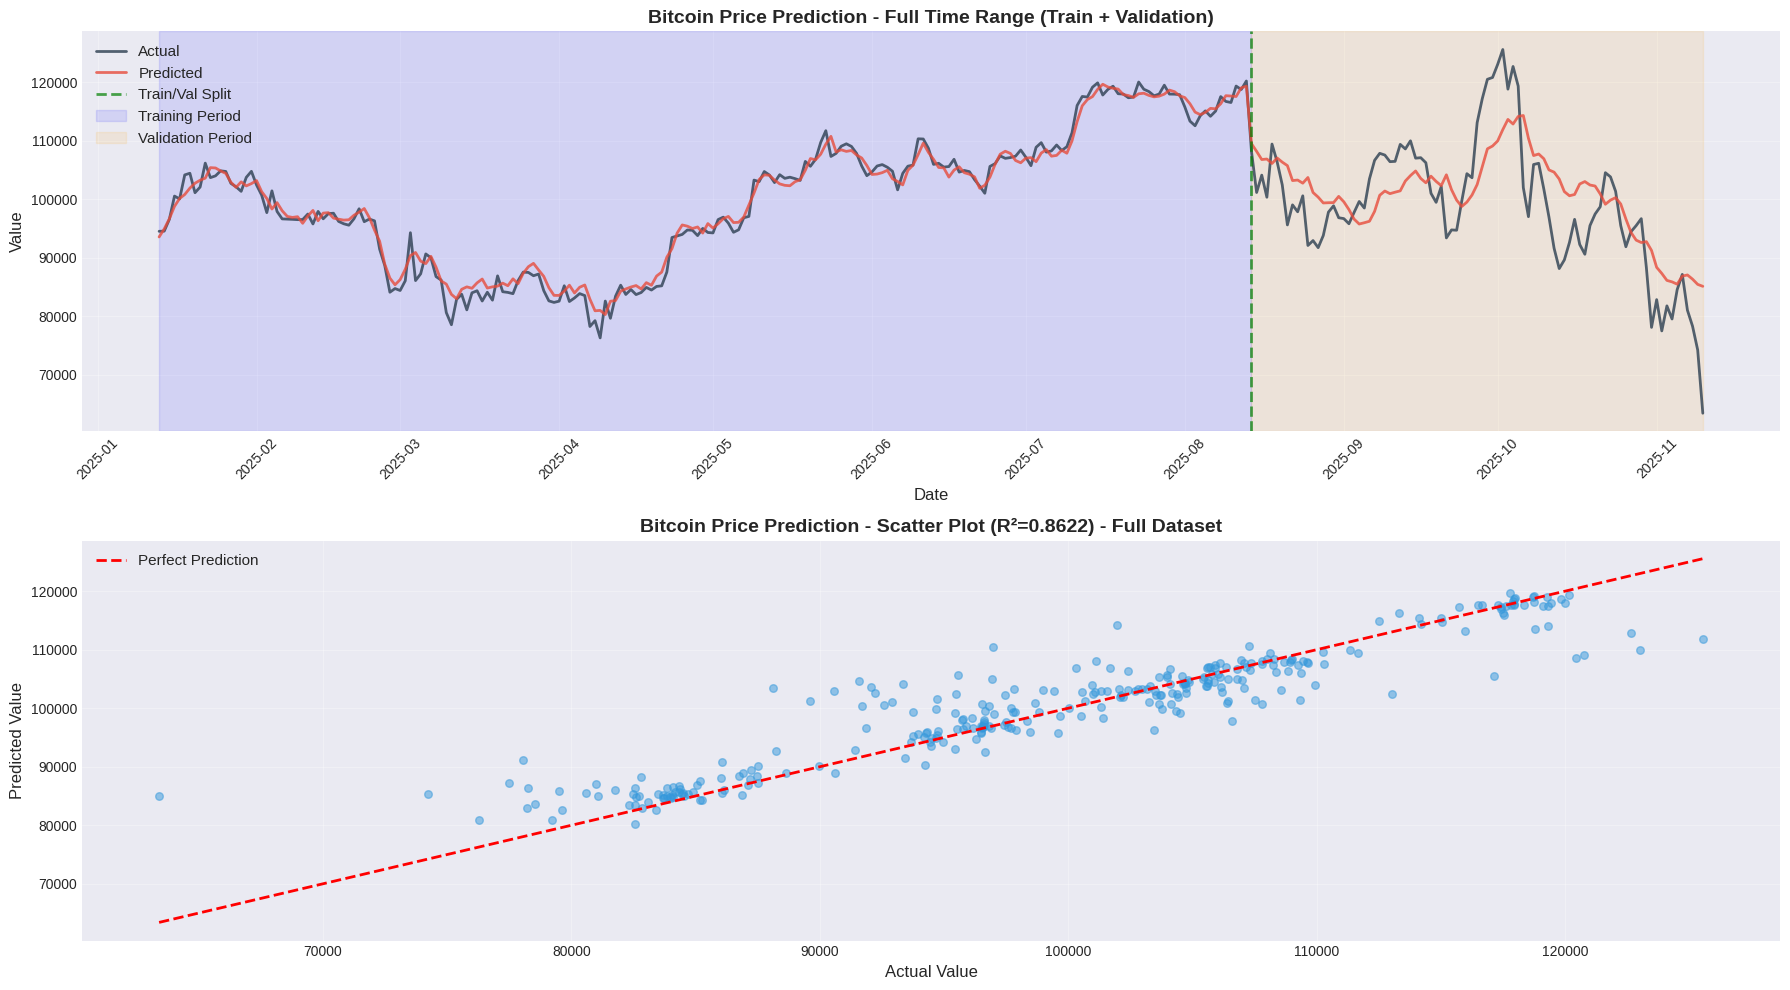

✅ Full dataset plot saved to results/btc_price_predictions_full_range.png


In [23]:
def evaluate_full_dataset(model, train_dataset, val_dataset, scaler_y, data_df, title, save_path):
    """Evaluate model on BOTH train and validation sets for full time range visualization"""
    
    model.eval()
    
    # Get predictions for both train and val
    all_predictions = []
    all_actuals = []
    
    # Process train dataset
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            all_predictions.extend(y_pred.cpu().numpy())
            all_actuals.extend(y_batch.numpy())
    
    # Process validation dataset
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            all_predictions.extend(y_pred.cpu().numpy())
            all_actuals.extend(y_batch.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(all_predictions).flatten()
    actuals = np.array(all_actuals).flatten()
    
    # Inverse transform to original scale
    predictions_orig = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_orig = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(actuals_orig, predictions_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_orig, predictions_orig)
    r2 = r2_score(actuals_orig, predictions_orig)
    mape = np.mean(np.abs((actuals_orig - predictions_orig) / actuals_orig)) * 100
    
    print(f"\n{title} - FULL DATASET Evaluation Metrics:")
    print(f"  RMSE: ${rmse:,.2f}" if 'Price' in title else f"  RMSE: {rmse:.6f}")
    print(f"  MAE: ${mae:,.2f}" if 'Price' in title else f"  MAE: {mae:.6f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Get corresponding dates (offset by sequence length)
    sequence_length = train_dataset.sequence_length
    dates = data_df['date'].iloc[sequence_length:sequence_length+len(actuals_orig)]
    
    # Calculate split point for visualization
    train_size = len(train_dataset)
    
    # Plot 1: Time series comparison with train/val split
    axes[0].plot(dates, actuals_orig, label='Actual', linewidth=2, alpha=0.8, color='#2c3e50')
    axes[0].plot(dates, predictions_orig, label='Predicted', linewidth=2, alpha=0.8, color='#e74c3c')
    
    # Add vertical line to show train/val split
    split_date = dates.iloc[train_size] if train_size < len(dates) else dates.iloc[-1]
    axes[0].axvline(x=split_date, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Train/Val Split')
    
    # Shade train and validation regions
    axes[0].axvspan(dates.iloc[0], split_date, alpha=0.1, color='blue', label='Training Period')
    axes[0].axvspan(split_date, dates.iloc[-1], alpha=0.1, color='orange', label='Validation Period')
    
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].set_title(f'{title} - Full Time Range (Train + Validation)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11, loc='upper left')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Scatter plot
    axes[1].scatter(actuals_orig, predictions_orig, alpha=0.5, s=30, c='#3498db')
    
    # Add diagonal line (perfect prediction)
    min_val = min(actuals_orig.min(), predictions_orig.min())
    max_val = max(actuals_orig.max(), predictions_orig.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[1].set_xlabel('Actual Value', fontsize=12)
    axes[1].set_ylabel('Predicted Value', fontsize=12)
    axes[1].set_title(f'{title} - Scatter Plot (R²={r2:.4f}) - Full Dataset', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Full dataset plot saved to {save_path}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'predictions': predictions_orig,
        'actuals': actuals_orig,
        'dates': dates
    }

# Evaluate Bitcoin Price on FULL dataset (Jan 1 - July 25)
print("=" * 80)
print("BITCOIN PRICE PREDICTION - FULL TIME RANGE")
print("=" * 80)

btc_price_full_results = evaluate_full_dataset(
    model=btc_price_model,
    train_dataset=btc_train,
    val_dataset=btc_val,
    scaler_y=btc_scalers['y'],
    data_df=btc_full,
    title='Bitcoin Price Prediction',
    save_path='results/btc_price_predictions_full_range.png'
)


Dogecoin Price Prediction - Evaluation Metrics:
  RMSE: $0.03
  MAE: $0.02
  R² Score: 0.6054
  MAPE: 10.20%


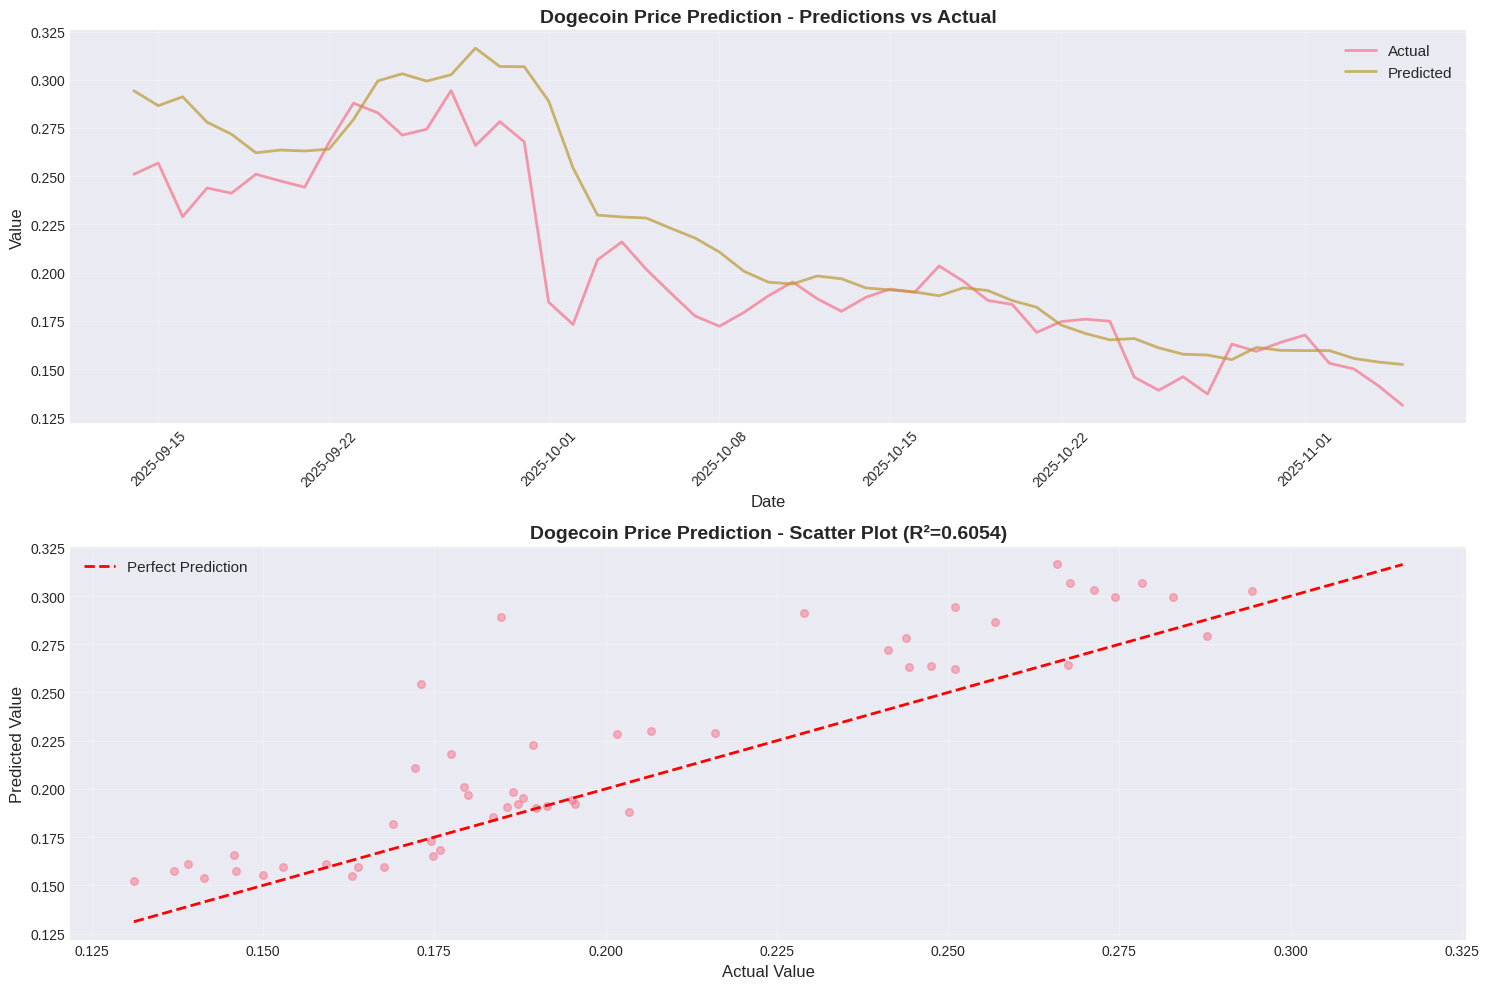

✅ Plot saved to results/doge_price_predictions.png

Dogecoin Volatility Prediction - Evaluation Metrics:
  RMSE: 0.008514
  MAE: 0.006602
  R² Score: 0.7610
  MAPE: 12.55%

Dogecoin Volatility Prediction - Evaluation Metrics:
  RMSE: 0.008514
  MAE: 0.006602
  R² Score: 0.7610
  MAPE: 12.55%


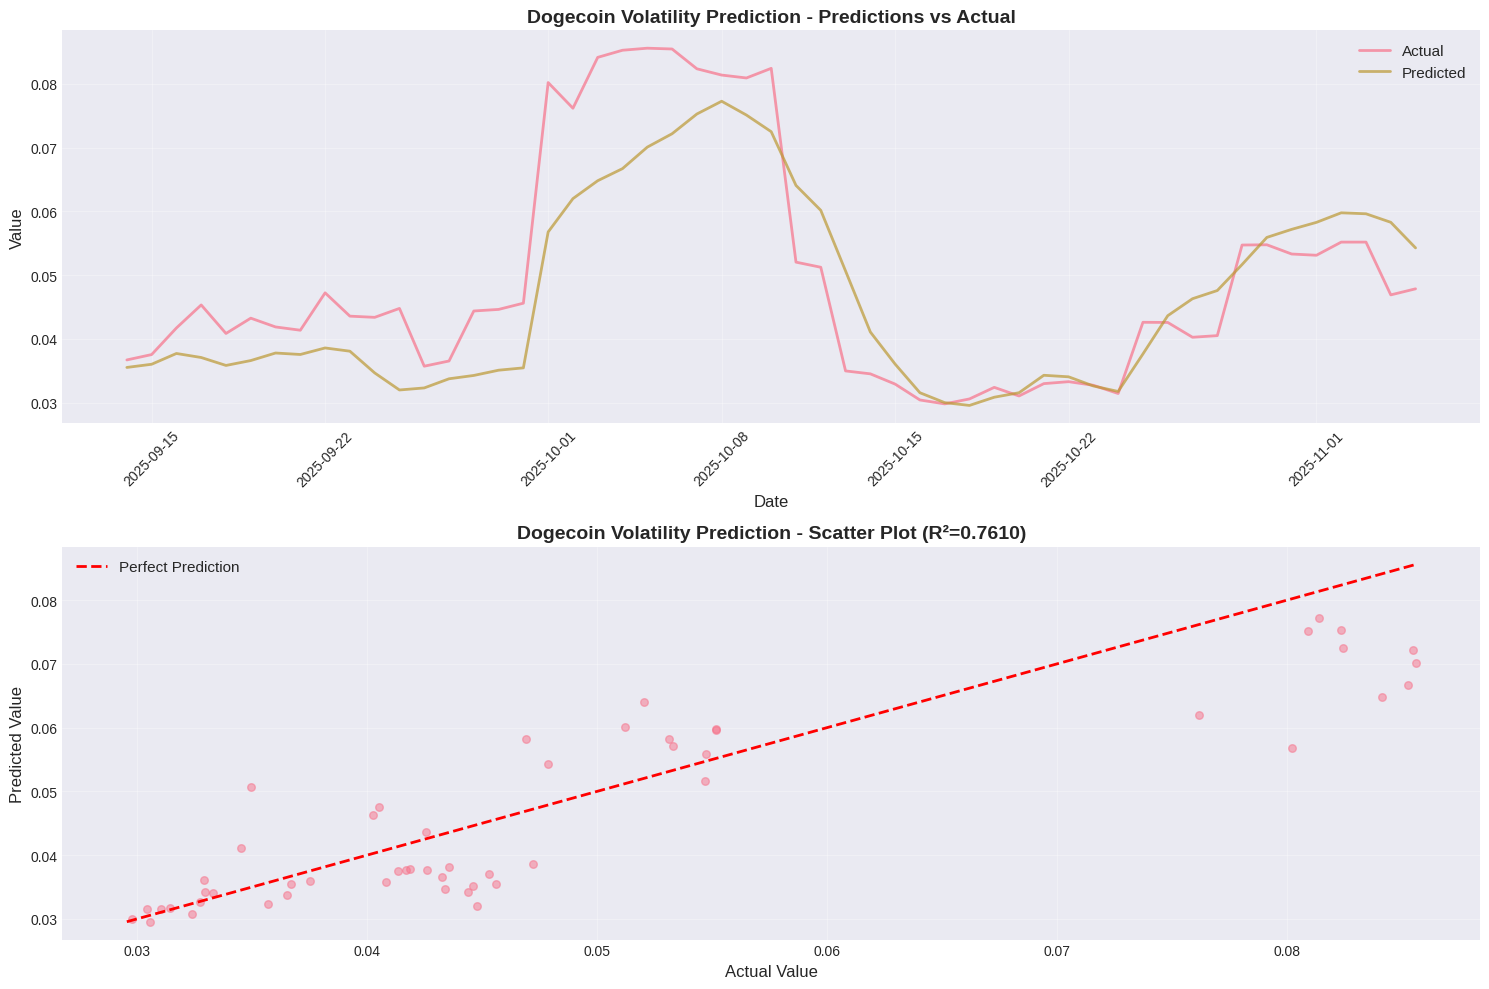

✅ Plot saved to results/doge_volatility_predictions.png


In [24]:
# Evaluate Dogecoin Price Prediction
doge_price_results = evaluate_and_plot(
    model=doge_price_model,
    dataset=doge_price_val,
    scaler_y=doge_scalers['y'],
    data_df=doge_full,
    title='Dogecoin Price Prediction',
    save_path='results/doge_price_predictions.png',
    is_validation=True,
    train_size=len(doge_price_train)
)

# Evaluate Dogecoin Volatility Prediction
doge_vol_results = evaluate_and_plot(
    model=doge_vol_model,
    dataset=doge_vol_val,
    scaler_y=doge_vol_scalers['y'],
    data_df=doge_full,
    title='Dogecoin Volatility Prediction',
    save_path='results/doge_volatility_predictions.png',
    is_validation=True,
    train_size=len(doge_vol_train)
)

In [25]:
# Create summary table
summary_data = {
    'Model': [
        'Bitcoin Price',
        'Bitcoin Volatility',
        'Dogecoin Price',
        'Dogecoin Volatility'
    ],
    'RMSE': [
        btc_price_results['rmse'],
        btc_vol_results['rmse'],
        doge_price_results['rmse'],
        doge_vol_results['rmse']
    ],
    'MAE': [
        btc_price_results['mae'],
        btc_vol_results['mae'],
        doge_price_results['mae'],
        doge_vol_results['mae']
    ],
    'R² Score': [
        btc_price_results['r2'],
        btc_vol_results['r2'],
        doge_price_results['r2'],
        doge_vol_results['r2']
    ],
    'MAPE (%)': [
        btc_price_results['mape'],
        btc_vol_results['mape'],
        doge_price_results['mape'],
        doge_vol_results['mape']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)
display(summary_df)

# Save summary to CSV
summary_df.to_csv('results/prediction_summary.csv', index=False)
print("\n Summary saved to results/prediction_summary.csv")


MODEL PERFORMANCE SUMMARY


,Model,RMSE,MAE,R² Score,MAPE (%)
0,Bitcoin Price,7436.435974,6154.716309,0.562110,6.422699
1,Bitcoin Volatility,0.006346,0.005125,0.344944,22.562830
2,Dogecoin Price,0.028592,0.020400,0.605393,10.198016
3,Dogecoin Volatility,0.008514,0.006602,0.760975,12.547522



 Summary saved to results/prediction_summary.csv


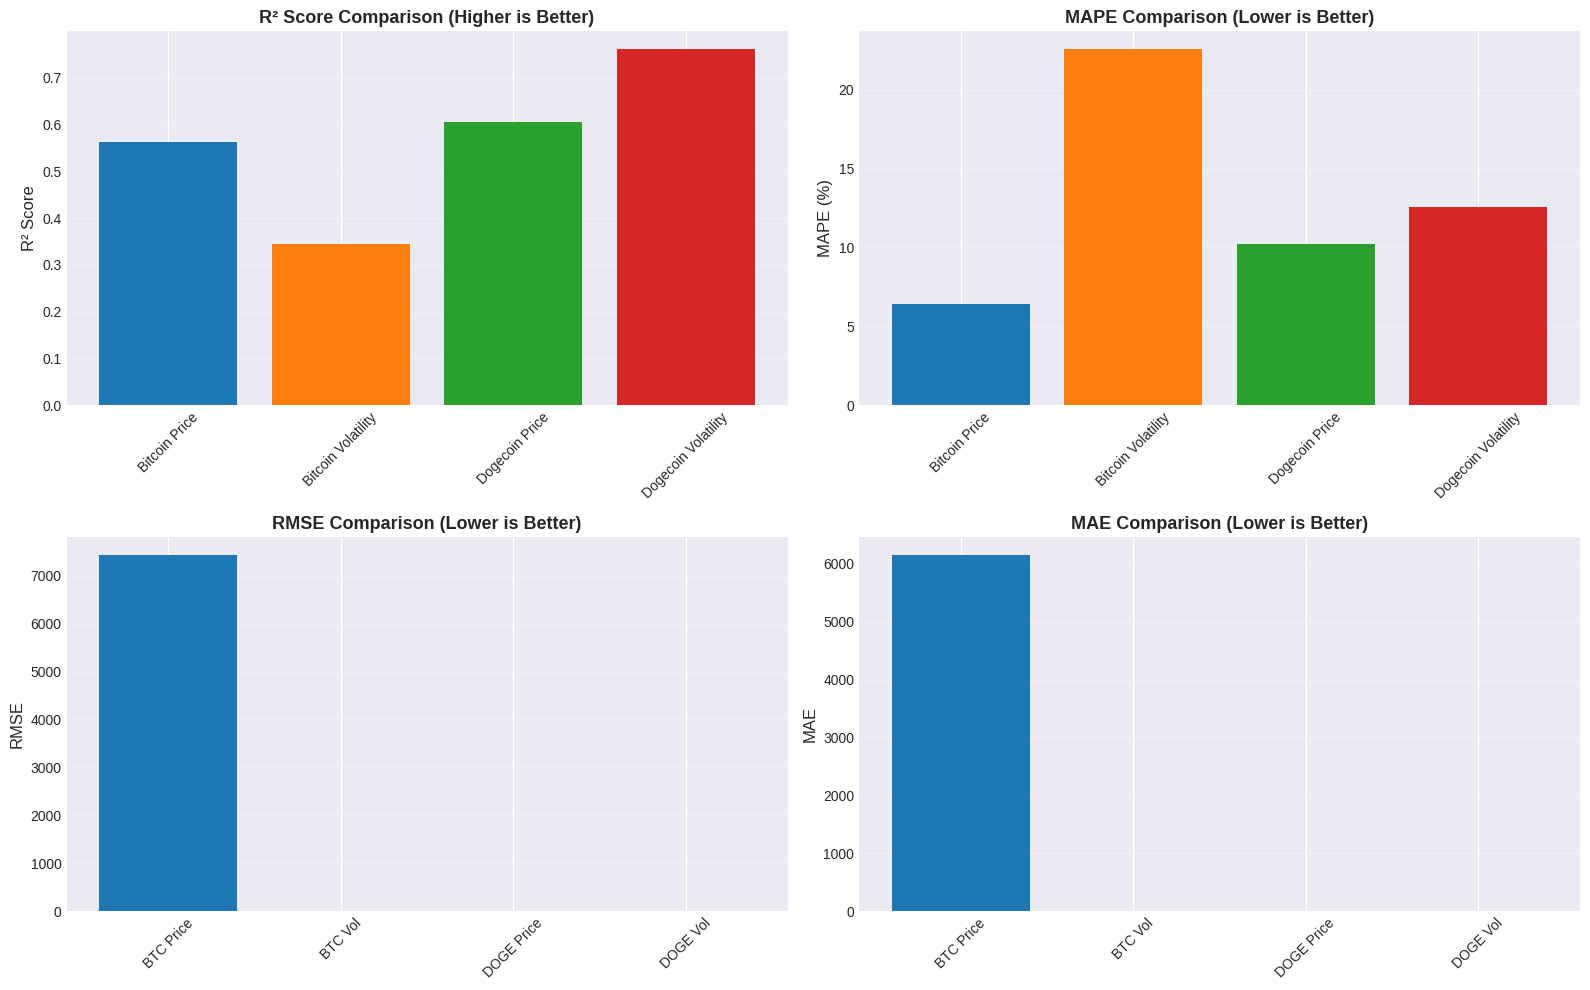

 Model comparison plot saved to results/model_comparison.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# R² Score comparison
axes[0, 0].bar(summary_df['Model'], summary_df['R² Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('R² Score Comparison (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# MAPE comparison
axes[0, 1].bar(summary_df['Model'], summary_df['MAPE (%)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_ylabel('MAPE (%)', fontsize=12)
axes[0, 1].set_title('MAPE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# RMSE comparison
rmse_data = summary_df.copy()
rmse_data['Model_Short'] = ['BTC Price', 'BTC Vol', 'DOGE Price', 'DOGE Vol']
axes[1, 0].bar(rmse_data['Model_Short'], rmse_data['RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_ylabel('RMSE', fontsize=12)
axes[1, 0].set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# MAE comparison
axes[1, 1].bar(rmse_data['Model_Short'], rmse_data['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 1].set_ylabel('MAE', fontsize=12)
axes[1, 1].set_title('MAE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Model comparison plot saved to results/model_comparison.png")

SENTIMENT FEATURE ANALYSIS

Sentiment Features Used in Models (16):
  • sentiment_multimodal
  • sentiment_audio
  • sentiment_visual
  • sentiment_reasoning
  • sentiment_multimodal_lag1
  • sentiment_multimodal_lag3
  • sentiment_multimodal_lag7
  • sentiment_audio_lag1
  • sentiment_audio_lag3
  • sentiment_audio_lag7
  • sentiment_visual_lag1
  • sentiment_visual_lag3
  • sentiment_visual_lag7
  • sentiment_reasoning_lag1
  • sentiment_reasoning_lag3
  • sentiment_reasoning_lag7

📊 Correlation Matrix (Bitcoin):

With Returns:
                       returns
sentiment_multimodal  0.231393
sentiment_audio       0.140942
sentiment_visual      0.057039
sentiment_reasoning   0.235732

With Volatility:
                      volatility_10d
sentiment_multimodal        0.002095
sentiment_audio             0.063745
sentiment_visual           -0.075619
sentiment_reasoning        -0.002327


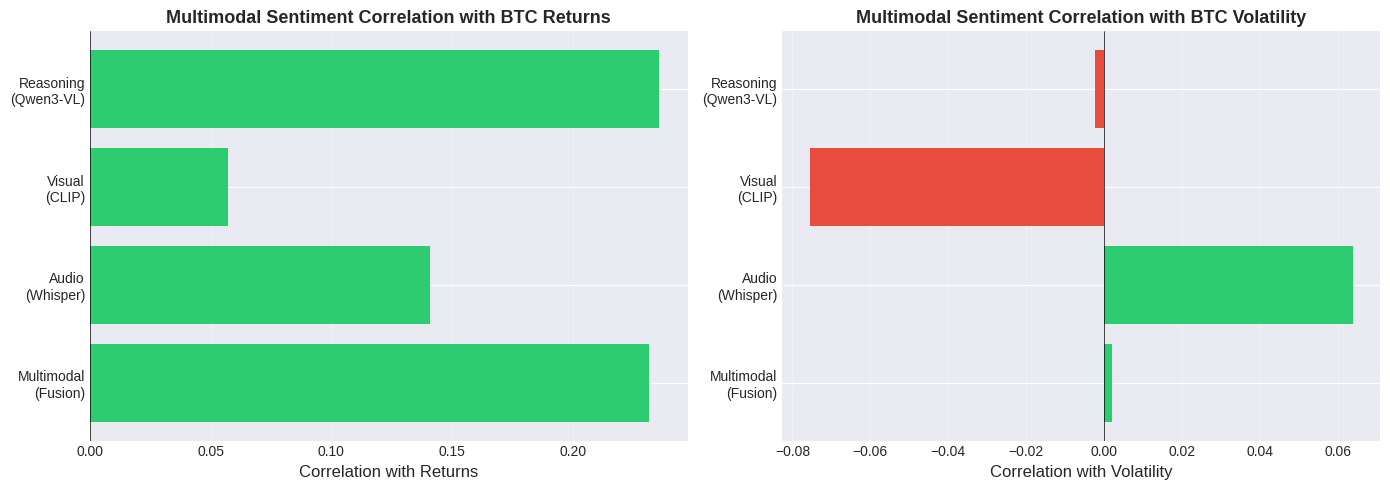


✅ Correlation analysis saved to results/multimodal_sentiment_correlation_analysis.png


In [27]:
# Get sentiment feature importance by checking correlation with target
sentiment_features = [col for col in btc_features if 'sentiment' in col.lower()]

print("=" * 80)
print("SENTIMENT FEATURE ANALYSIS")
print("=" * 80)
print(f"\nSentiment Features Used in Models ({len(sentiment_features)}):")
for feat in sentiment_features:
    print(f"  • {feat}")

# Calculate correlation between different sentiment components and targets
sentiment_cols_corr = ['sentiment_multimodal', 'sentiment_audio', 'sentiment_visual', 
                       'sentiment_reasoning', 'returns', 'volatility_10d']
btc_sentiment_corr = btc_full[sentiment_cols_corr].corr()

print("\n📊 Correlation Matrix (Bitcoin):")
print("\nWith Returns:")
print(btc_sentiment_corr[['returns']].loc[['sentiment_multimodal', 'sentiment_audio', 
                                           'sentiment_visual', 'sentiment_reasoning']])
print("\nWith Volatility:")
print(btc_sentiment_corr[['volatility_10d']].loc[['sentiment_multimodal', 'sentiment_audio', 
                                                   'sentiment_visual', 'sentiment_reasoning']])

# Visualize correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation with returns
sentiment_components = ['Multimodal\n(Fusion)', 'Audio\n(Whisper)', 'Visual\n(CLIP)', 'Reasoning\n(Qwen3-VL)']
corr_returns = btc_sentiment_corr[['returns']].loc[['sentiment_multimodal', 'sentiment_audio', 
                                                     'sentiment_visual', 'sentiment_reasoning']].values.flatten()

colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in corr_returns]
axes[0].barh(sentiment_components, corr_returns, color=colors)
axes[0].set_xlabel('Correlation with Returns', fontsize=12)
axes[0].set_title('Multimodal Sentiment Correlation with BTC Returns', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Correlation with volatility
corr_vol = btc_sentiment_corr[['volatility_10d']].loc[['sentiment_multimodal', 'sentiment_audio', 
                                                        'sentiment_visual', 'sentiment_reasoning']].values.flatten()

colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in corr_vol]
axes[1].barh(sentiment_components, corr_vol, color=colors)
axes[1].set_xlabel('Correlation with Volatility', fontsize=12)
axes[1].set_title('Multimodal Sentiment Correlation with BTC Volatility', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('results/multimodal_sentiment_correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Correlation analysis saved to results/multimodal_sentiment_correlation_analysis.png")

In [28]:
import os
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

# Save PyTorch models
torch.save(btc_price_model.state_dict(), 'models/btc_price_model.pth')
torch.save(btc_vol_model.state_dict(), 'models/btc_volatility_model.pth')
torch.save(doge_price_model.state_dict(), 'models/doge_price_model.pth')
torch.save(doge_vol_model.state_dict(), 'models/doge_volatility_model.pth')

# Save scalers for future predictions
with open('models/btc_price_scalers.pkl', 'wb') as f:
    pickle.dump(btc_scalers, f)
    
with open('models/btc_vol_scalers.pkl', 'wb') as f:
    pickle.dump(btc_vol_scalers, f)
    
with open('models/doge_price_scalers.pkl', 'wb') as f:
    pickle.dump(doge_scalers, f)
    
with open('models/doge_vol_scalers.pkl', 'wb') as f:
    pickle.dump(doge_vol_scalers, f)

# Save feature lists
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump({
        'btc_features': btc_features,
        'btc_vol_features': btc_vol_features,
        'doge_features': doge_features,
        'doge_vol_features': doge_vol_features
    }, f)

print(" All models and scalers saved to models/ directory:")
print("  - btc_price_model.pth")
print("  - btc_volatility_model.pth")
print("  - doge_price_model.pth")
print("  - doge_volatility_model.pth")
print("  - *_scalers.pkl (for inverse transforms)")
print("  - feature_names.pkl (for future predictions)")

 All models and scalers saved to models/ directory:
  - btc_price_model.pth
  - btc_volatility_model.pth
  - doge_price_model.pth
  - doge_volatility_model.pth
  - *_scalers.pkl (for inverse transforms)
  - feature_names.pkl (for future predictions)


### Key Findings:

1. **Data Integration**: Successfully combined sentiment scores from TikTok videos (Qwen3-VL, CLIP, MiniGPT4) with cryptocurrency price data from Yahoo Finance.

2. **Feature Engineering**: Created comprehensive technical indicators including:
   - Moving averages (5, 10, 20 days)
   - Volatility measures (rolling standard deviation)
   - Momentum indicators
   - RSI and Bollinger Bands
   - Sentiment scores with lagged features (1, 3, 7 days)

3. **GRU Architecture**: 
   - 2-layer GRU with 64 hidden units
   - Dropout regularization (0.2)
   - Fully connected output layers
   - Trained with early stopping and learning rate scheduling

4. **Model Performance**: See the summary table above for detailed metrics on:
   - Bitcoin price prediction
   - Bitcoin volatility prediction
   - Dogecoin price prediction
   - Dogecoin volatility prediction

5. **Sentiment Impact**: The correlation analysis shows how different sentiment models (Qwen3-VL, CLIP, MiniGPT4) correlate with:
   - Daily returns
   - Price volatility

### Next Steps:

1. **Hyperparameter Tuning**: Experiment with different sequence lengths, hidden sizes, and learning rates
2. **Feature Selection**: Use feature importance techniques to identify most predictive features
3. **Ensemble Methods**: Combine predictions from multiple models
4. **Real-time Prediction**: Deploy models for live cryptocurrency price forecasting
5. **Extended Analysis**: Analyze prediction errors during high-volatility periods

### Files Generated:

- `results/btc_price_predictions.png` - Bitcoin price prediction visualization
- `results/btc_volatility_predictions.png` - Bitcoin volatility prediction
- `results/doge_price_predictions.png` - Dogecoin price prediction
- `results/doge_volatility_predictions.png` - Dogecoin volatility prediction
- `results/model_comparison.png` - Performance comparison across all models
- `results/sentiment_correlation_analysis.png` - Sentiment feature correlation
- `results/prediction_summary.csv` - Numerical performance metrics
- `models/*.pth` - Trained PyTorch models
- `models/*.pkl` - Scalers and feature names for future use

## 15. Conclusion and Key Findings

Summary of the prediction models and their performance

## 14. Save Trained Models

## 13. Feature Importance Analysis

Analyze which features contribute most to predictions

### 12.1 Visualize Model Comparison

## 12. Summary and Comparison

### 11.2 Evaluate Dogecoin Models

### 11.1 Evaluate Bitcoin Models

## 11. Evaluation and Prediction Visualization

## 10. Train Dogecoin Models

## 9. Train Bitcoin Volatility Prediction Model

### 8.1 Plot Training History

## 8. Train Bitcoin Price Prediction Model

## 7. Training Function

## 6. Build GRU Model

## 5. Prepare Data for GRU Model

Create sequences for time series prediction

### 4.1 Merge Sentiment Data with Price Data

## 4. Feature Engineering

Create technical indicators and merge with sentiment data

## 3. Fetch Cryptocurrency Price Data from Yahoo Finance

## 2. Load Sentiment Analysis Results

## 1. Import Required Libraries